In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.8 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

!pip install utils
#!pip install learning

Cloning into 'kaggle-environments'...
remote: Enumerating objects: 4311, done.
remote: Counting objects: 100% (1091/1091), done.
remote: Compressing objects: 100% (317/317), done.
remote: Total 4311 (delta 871), reused 925 (delta 772), pack-reused 3220
Receiving objects: 100% (4311/4311), 11.00 MiB | 16.47 MiB/s, done.
Resolving deltas: 100% (2630/2630), done.
Processing /content/kaggle-environments
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for kaggle-environments: filename=kaggle_environments-1.9.9-py3-none-any.whl size=1820377 sha256=6f43f15b0a98b8e8dddd3f7fd483d8f1

In [27]:
#from gfootball.env.football_env import FootballEnv
from kaggle_environments import make
from gfootball.env.config import Config
import gfootball.env as football_env

#import dqn libraries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import utils
import random
from collections import deque
import matplotlib.pyplot as plt
#from utils import plot_learning_curve
#import env 
import gym
import gfootball 
import math

#env_name = "GFootballBase-v0"
#print(env_name)

In [3]:
class DeepQNetwork(nn.Module):
  def __init__(self,lr,input_dims,fc1_dims,fc2_dims,fc3_dims,n_actions):
    super(DeepQNetwork,self).__init__()
   # self.lr=lr
    self.input_dims=input_dims
    self.fc1_dims=fc1_dims
    self.fc2_dims=fc2_dims
    self.fc3_dims=fc3_dims
    self.n_actions=n_actions
    
    self.fc1=nn.Linear(*self.input_dims,self.fc1_dims) #pass list of observations as input
    self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
    self.fc3=nn.Linear(self.fc2_dims,self.fc3_dims)
    self.fc3=nn.Linear(self.fc3_dims,self.n_actions) #output number action

    self.optimizer = optim.Adam(self.parameters(),lr=lr)
    self.loss=nn.MSELoss()
    self.device =T.device('cuda:0' if T.cuda.is_available() else 'cpu' )
    self.to(self.device)

  def forward(self,state):
   
    x=F.relu(self.fc1(state))
    x=F.relu(self.fc2(x))
    actions=self.fc3(x)
      
    return actions


In [5]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,rew_list,eps_reward,epsilon):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.rew_list=rew_list
    self.eps_reward=eps_reward
    self.epsilon=epsilon
    print("-->Episode:",i%3000 + 1,"\t","Episode Reward:",eps_reward,"\t Epsilon",agent.epsilon,"<--")
    #print("Step",step)
    print("lista apo rewards mexri tora" ,self.rew_list)
    print("Avg reward", np.mean(self.rew_list))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==1):
      print("our team scored !!!")
    elif(self.reward ==-1):
      print("opponent team scored")
    
    
 
  def rew_graph(self,rew_list,num_of_eps):
      self.rew_list=rew_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.rew_list)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()


  def score_graph(self,score_list,num_of_eps):
      self.score_list=score_list
      
      self.num_of_eps=num_of_eps
      
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      
      plt.plot(eps_list,self.score_list)
      plt.xlabel('Episode')
      plt.ylabel('Score')
      plt.grid(True)
      plt.show()

In [23]:
class Agent():
  def __init__(self,gamma,epsilon, lr , input_dims , batch_size ,n_actions, max_mem_size = 20000  , eps_end=0.01 , eps_dec = 5e-4):
    self.gamma=gamma
    self.epsilon =epsilon
    self.lr=lr
    self.eps_min=eps_end
    self.eps_dec=eps_dec
   
    self.action_space =[i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.n_actions=n_actions
    self.mem_cntr =0 # keep track of the position of first available memory 

    self.Q_eval = DeepQNetwork(self.lr,n_actions=n_actions,input_dims= input_dims, fc1_dims=500, fc2_dims=500 , fc3_dims=500)

    self.state_memory = np.zeros((self.mem_size,*input_dims),dtype =np.float32)
    self.new_state_memory= np.zeros((self.mem_size , *input_dims),dtype=np.float32)

    self.action_memory=np.zeros(self.mem_size , dtype=np.int32) #discrete actions (19)
    self.reward_memory=np.zeros(self.mem_size,dtype= np.float32)
    self.terminal_memory= np.zeros(self.mem_size,dtype=bool)


  def store_transition(self,state,action,reward,new_state , done ):
    index = self.mem_cntr% self.mem_size

    self.state_memory[index]= state
    self.new_state_memory[index]= new_state
    self.reward_memory[index]= reward
    self.action_memory[index]= action  #which action is taken 
    self.terminal_memory[index]= done

    self.mem_cntr +=1
    

  def choose_action(self,observation):
    if np.random.random()> self.epsilon:
      
      state =T.tensor([observation]).to(self.Q_eval.device) #turn observation to tensor and send it to device for computations
      action_list = self.Q_eval.forward(state) #returns the values of each action
      action = T.argmax(action_list).item()
      #print("exploit:",action)
    else:     #
      
      action = np.random.choice(self.action_space)
      #print("explore:",action)
    return action

  def learn(self):    #fill batch size then learn 
    if self.mem_cntr < self.batch_size :
      return
    
    
    self.Q_eval.optimizer.zero_grad()

    #calculate the position of max memory / extract subset of max memories
    max_mem =min(self.mem_cntr , self.mem_size)
    for i in range(self.mem_size//self.batch_size):
      batch=np.random.choice(max_mem,self.batch_size,replace=False) #We dont keep selecting the same memories more than once
     
      #batch=np.random.choice(max_mem,self.batch_size,replace=False)
      batch_index = np.arange(self.batch_size , dtype=np.int32)

      state_batch=T.tensor(self.state_memory[batch]).to(self.Q_eval.device) #make numpy array a pytorch tensor
      new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
      reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
      terminal_batch= T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

      action_batch = self.action_memory[batch] 
    
      q_eval = self.Q_eval.forward(state_batch)[batch_index,action_batch] #EXEI THEMA
      q_next = self.Q_eval.forward(new_state_batch)

      q_next[terminal_batch] = 0.0
      q_target = reward_batch +self.gamma * T.max(q_next,dim=1)[0] #max value of next state

      loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
      loss.backward()
      self.Q_eval.optimizer.step()

      self.epsilon = self.epsilon - self.eps_dec if (self.epsilon > self.eps_min)  else self.eps_min
      

shout ektos periohis episode 0
Avg reward last: -201.59102664363132 Avg score last 0.0 Avg steps 18.0 episode= 0
shout entos periohis episode 3
shout entos periohis episode 4
ball is out -10 episode 4
shout ektos periohis episode 5
shout entos periohis episode 7
shout entos periohis episode 9
shout entos periohis episode 9
shout entos periohis episode 9
shout entos periohis episode 10
Avg reward last: -21.64354779386437 Avg score last 0.8 Avg steps 81.3 episode= 10
shout ektos periohis episode 11
ball is out -10 episode 12
shout entos periohis episode 19
shout entos periohis episode 19
ball is out -10 episode 20
Avg reward last: -22.60457037008529 Avg score last 0.7 Avg steps 69.7 episode= 20
shout entos periohis episode 21
shout entos periohis episode 21
shout entos periohis episode 24
shout entos periohis episode 25
ball is out -10 episode 26
Avg reward last: -0.8843294267806329 Avg score last 0.9 Avg steps 73.6 episode= 30
shout ektos periohis episode 31
shout entos periohis episode

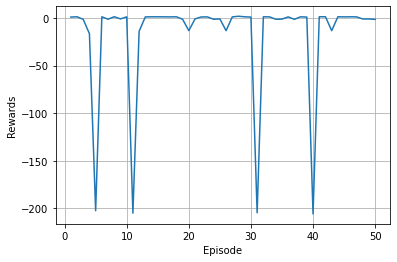

shout entos periohis episode 52
shout entos periohis episode 53
shout entos periohis episode 53
shout entos periohis episode 56
shout entos periohis episode 57
shout entos periohis episode 57
ball is out -10 episode 57
shout entos periohis episode 58
ball is out -10 episode 58
ball is out -10 episode 60
Avg reward last: -4.473195024639619 Avg score last 0.7 Avg steps 87.8 episode= 60
shout entos periohis episode 61
ball is out -10 episode 61
shout entos periohis episode 63
shout entos periohis episode 63
shout entos periohis episode 63
shout entos periohis episode 65
shout entos periohis episode 65
shout ektos periohis episode 66
shout ektos periohis episode 67
Avg reward last: -42.3128797364007 Avg score last 0.7 Avg steps 80.9 episode= 70
Avg reward last: 1.288196139721848 Avg score last 1.0 Avg steps 67.4 episode= 80
ball is out -10 episode 83
ball is out -10 episode 84
ball is out -10 episode 85
shout entos periohis episode 89
shout entos periohis episode 89
ball is out -10 episode

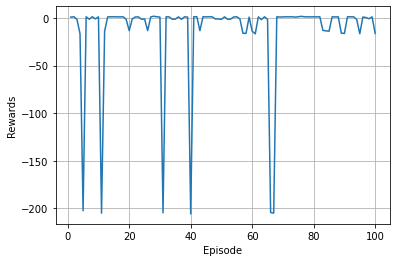

shout entos periohis episode 102
shout entos periohis episode 102
ball is out -10 episode 104
shout entos periohis episode 107
shout entos periohis episode 107
shout entos periohis episode 107
shout entos periohis episode 109
Avg reward last: -0.7415075838753762 Avg score last 0.9 Avg steps 76.0 episode= 110
shout entos periohis episode 111
shout entos periohis episode 111
shout entos periohis episode 113
shout entos periohis episode 113
shout entos periohis episode 114
shout entos periohis episode 116
shout entos periohis episode 116
shout entos periohis episode 116
ball is out -10 episode 117
shout entos periohis episode 118
ball is out -10 episode 118
shout entos periohis episode 119
shout entos periohis episode 119
Avg reward last: -2.8451723928600767 Avg score last 0.8 Avg steps 83.4 episode= 120
shout entos periohis episode 121
shout entos periohis episode 121
shout ektos periohis episode 125
shout ektos periohis episode 127
shout entos periohis episode 129
shout entos periohis e

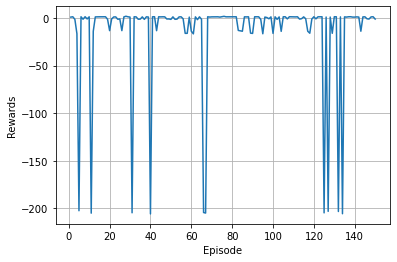

shout entos periohis episode 155
shout entos periohis episode 156
shout entos periohis episode 156
shout entos periohis episode 157
shout entos periohis episode 157
shout entos periohis episode 157
shout ektos periohis episode 160
Avg reward last: -19.88510103124662 Avg score last 0.9 Avg steps 75.8 episode= 160
shout entos periohis episode 163
shout entos periohis episode 163
shout entos periohis episode 163
ball is out -10 episode 163
shout entos periohis episode 165
shout ektos periohis episode 166
shout ektos periohis episode 168
Avg reward last: -41.72928636674952 Avg score last 0.7 Avg steps 71.0 episode= 170
shout ektos periohis episode 172
ball is out -10 episode 175
shout entos periohis episode 176
shout entos periohis episode 176
shout entos periohis episode 176
shout entos periohis episode 178
Avg reward last: -21.35828360044665 Avg score last 0.8 Avg steps 76.9 episode= 180
ball is out -10 episode 183
shout entos periohis episode 187
shout entos periohis episode 187
shout e

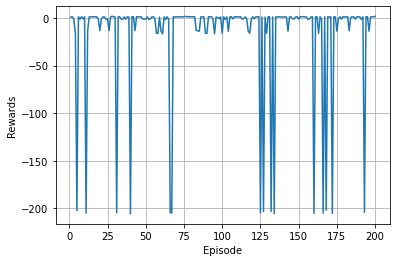

ball is out -10 episode 202
shout ektos periohis episode 206
shout ektos periohis episode 207
shout entos periohis episode 209
shout entos periohis episode 209
shout entos periohis episode 210
shout entos periohis episode 210
Avg reward last: -41.40433980604334 Avg score last 0.7 Avg steps 64.9 episode= 210
shout entos periohis episode 213
shout entos periohis episode 214
shout entos periohis episode 214
shout entos periohis episode 215
shout entos periohis episode 217
shout ektos periohis episode 218
shout entos periohis episode 220
shout entos periohis episode 220
ball is out -10 episode 220
Avg reward last: -21.968019455851245 Avg score last 0.8 Avg steps 82.1 episode= 220
shout entos periohis episode 221
shout entos periohis episode 222
shout entos periohis episode 223
shout entos periohis episode 223
shout ektos periohis episode 226
shout entos periohis episode 227
shout entos periohis episode 227
Avg reward last: -19.929988209529295 Avg score last 0.9 Avg steps 76.7 episode= 230


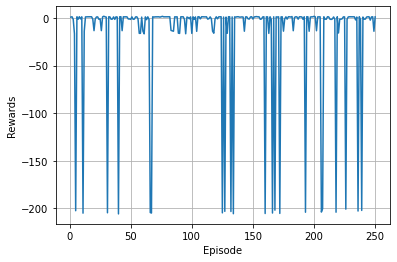

shout entos periohis episode 251
shout entos periohis episode 251
shout entos periohis episode 254
shout entos periohis episode 255
ball is out -10 episode 255
shout entos periohis episode 256
shout entos periohis episode 256
shout entos periohis episode 257
shout entos periohis episode 257
shout ektos periohis episode 258
shout entos periohis episode 259
shout entos periohis episode 259
Avg reward last: -22.465811806852322 Avg score last 0.8 Avg steps 92.4 episode= 260
shout entos periohis episode 262
shout entos periohis episode 265
shout ektos periohis episode 266
shout entos periohis episode 268
shout entos periohis episode 268
shout entos periohis episode 269
shout entos periohis episode 269
Avg reward last: -20.107112274669596 Avg score last 0.9 Avg steps 77.4 episode= 270
shout entos periohis episode 271
shout entos periohis episode 273
ball is out -10 episode 273
shout entos periohis episode 275
ball is out -10 episode 275
shout entos periohis episode 280
Avg reward last: -2.76

KeyboardInterrupt: ignored

In [31]:
#ANALYTIKA SXOLIA SE OLO TON KODIKA - MHN AFHSEIS KATI XORIS NA TO KATALABEIS
#TODO: if active player far from the ball, the reward will lose by the moving distance ---if we go out the square, the reward will lose - forward move else lose
#TODO: FTIAKSE PIO POLY TA CUSTOM REWARDS
#TODO:TYPOMA GRAMMI GRAMMI NA DEIS TIN EKPAIDEYSI
#TODO: MAKE BIGGER BATCHES



#if __name__ == '__main__':
#env = football_env.create_environment(env_name ='11_vs_11_easy_stochastic',render=False,representation='simple115')  #List with the 115 states 
env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115v2')  #List with the 115 states 
#env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states
#env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_pass_and_shoot_with_keeper',render=False,representation='simple115')
#env = football_env.create_environment(env_name ='academy_empty_goal',render=False,representation='simple115')  #List with the 115 states 

#CUSTOMIZE ACTION LIST AND OBSERVATIONS
Action_list=[4,5,6,12]

#Create Objects

agent = Agent(gamma=0.99,epsilon=1.0 ,batch_size = 128 ,lr=0.00015 ,input_dims= [115], n_actions = len(Action_list) )# batch = best 256
all_prints = All_prints()
#cus_rew =Custom_Rewards()

scores,ep_history =[],[]

steps=0
terminal =0
episode =0



num_of_eps = 1000
eps_rew=0
rew_list =[]
score_list = []
step_list =[]
for i in range(num_of_eps) : 
  score =0 
  done=False 
  observation =env.reset()
  act =0 #first action will be to move right 
  while not done:

    #CUSTOMIZE ACTIONS HERE 
    #An einai i mpala sto 0.5 kai exo katoxi kane shout diladi action 12
    
    #print("------------")
    #print("Ball X-Y-Z Axis",observation[88],observation[89],observation[90],"||","direct",observation[91],observation[92],observation[93],"Katoxi",observation[95],observation[96])
    #print("Player X-Axis Y-Axis",observation[2],observation[3] ,"episode",i)
    #print("------------")

    #na bazei goal aytomata
    #if(observation[2]>0.6 and observation[95] == 1):
      
      
      #print("EXO MPALA",12)
      #new_observation,reward,done,info = env.step(12) #kanei shout Action 12

      #print("ball position",observation[88], "Action taken", action)
     
      
 
    if(act ==0 ):
      
      # print("action 5",Action_list[action])
      new_observation,reward,done,info = env.step(5)
      act=1
    #print("Sto Else",observation[94],observation[95],observation[96])
    

    
    action = agent.choose_action(observation)
    
    
    new_observation,reward,done,info = env.step(Action_list[action])

    #if(reward!=1):  #each step loses -0.2
      #reward= reward -0.2
    
    

    if(done ==1 and reward !=1): #if ball is out ,loses -2
      reward = reward -10
      print("ball is out -10","episode",i,"step=",steps)
    if(reward==1 and  done ==1): #if agent scores , wins +5
      reward = 5


    if((observation[2]<0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei prin th megali perioxh -2
      
      reward= reward -200
      done=1
      print("shout ektos periohis","episode",i,"step=",steps)

    if((observation[2]>0.5) and (observation[95] == 1) and (Action_list[action]==12)): #an shoutarei mesa ti megali periohi +0.1
      #reward= reward +0.1
      print("shout entos periohis","episode",i,"step=",steps)
      
    reward = reward - ( math.sqrt( ((0.935 - observation[2])**2) + (0 -observation[3])**2 ) *0.1) #oso pio makria einai toso perissotero xanei
    #print("Den exo mpala",Action_list[action])
    #print("DEN EXO MPALA",Action_list[action],action)

    #custom reward here
 
    
    #if( ((observation[88]>0.99) and (observation[95]==1)) or  ((observation[89]>0.39) and (observation[95]==1)) or ((observation[89] < -0.39)and(observation[95]==1)) ):
      #reward =-2
      #print("bgike ektos")
    #if((reward!=1) or (reward!=-1)):
      #reward =cus_rew.custom_rew(observation,action,reward,new_observation)
    score= +reward

    #for prints
    eps_rew+=reward
    #all_prints.print_who_scored(reward)
    

    agent.store_transition(observation,action,reward,new_observation,done)
    agent.learn()
    observation = new_observation

    scores.append(score)
    ep_history.append(agent.epsilon)

    avg_score= np.mean(scores)


    steps=steps+1
    
#---- BE CAREFUL OF THE WHILE !!! HERE IS EPIDOSE ENDING--------
  #print("Reward",eps_rew,"Episode",i,"Steps" , steps)
  step_list.append(steps)
  steps=0

  val = info.values()
  list_val=list(val)
  score_list.append(list_val)
  
  #terminate if 500 episodes are correct 
  if(eps_rew == 1 ):
    terminal= terminal +1
    if(terminal == 500):
      print("500 Episodes with goal")
      break
  else:
      terminal =0 
  episode = episode +1 
  

  rew_list.append(eps_rew)

# PRINTS
  if (i % 10)== 0 :
      print("---Avg reward last:", np.mean(rew_list[-10:]),"Avg score last",np.mean(score_list[-10:]),"Avg steps",np.mean(step_list[-10:]),"episode=",i,"---")
      #print(score_list)

  if (((i % 1000)== 0) and i!=0) :
      all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
  if(((i%50)==0) and i!=0):
    all_prints.rew_graph(rew_list[-i:],i)
     
  
  #EPISODE PRINTS
  #all_prints.printstats(i,rew_list,eps_rew,agent.epsilon)
  
  eps_rew=0



print("Avg score last:", np.mean(rew_list[-10:]),"Avg score",np.mean(score_list),"Avg steps",np.mean(step_list[-10:]),"episode=",i)
all_prints.score_graph(score_list[-1000:],1000)# graph the last 1000 episodes
      
#all_prints.score_graph(score_list,i+1)#i = num_of_eps
#print("\n ")
#all_prints.rew_graph(rew_list,i+1)


In [ ]:
class Custom_Rewards():
  #def __init__(self):
    #self.obs=obs    
    #self.action=action
    #self.reward =reward
  def custom_rew(self,obs,action,reward,new_obs):
    
    self.obs=obs
    self.action = action
    self.reward = reward
    self.new_obs=new_obs
    
    
#if the next action is shooting the ball, the reward will gain 0.2 point ||
#an exo ti mpala kai einai se apostasi x > 0.5 sto gipedo kai exei kanei shout einai kalo    
    if(self.obs[95] == 1 and self.obs[88] > 0.6 and self.action == 12):
      self.reward += 0.02
      #print("EKANE SHOUT MPROSTA APO TO KENTRO ,+0.1")
      return self.reward

    #An kanei shout piso apo to kentro na xanei ligo
    elif(self.obs[95]==1 and self.obs[88] < 0 and self.action == 12):
      self.reward -= 0.02
      #print("EKANE SHOUT PISO APO TO KENTRO, -0.05")
      return self.reward

# if we steal the ball, the reward will gain 0.05 points
    elif self.obs[96] == 1 and self.new_obs[95] == 1:  #obs[96] ball owner right team / obs[95] ball owner left team
        self.reward += 0.05
        #print("PHRE THN MPALA APO TON ANTIPALO , +0.05")
        return self.reward
#if we lose the ball, the reward will lose 0.05 points
    elif self.obs[95] == 1 and self.new_obs[96] == 1:
        self.reward -=0.02
        #print("PHRE THN MPALA O ANTIPALOS , -0.02")
        return self.reward
    else:
      return self.reward


#TODO: if active player far from the ball, the reward will lose by the moving distance

In [ ]:
#print(score_list or reward_list)

In [ ]:

"""print(observation)
new_observation,reward,done,info = env.step(4)
print(new_observation)"""

'print(observation)\nnew_observation,reward,done,info = env.step(4)\nprint(new_observation)'

In [ ]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [ ]:
"""env = football_env.create_environment(env_name ='academy_single_goal_versus_lazy',render=False,representation='simple115')
observation =env.reset()
new_observation,reward,done,info = env.step(action)
val=info.values()
print(val)
list_val=list(val)
list_val"""